In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import ks_2samp
from itertools import product


from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sklearn.impute import SimpleImputer, KNNImputer
from sksurv.util import Surv
from sklearn.preprocessing import StandardScaler,RobustScaler, OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import lightgbm as lgb

%matplotlib inline 
plt.style.use('dark_background')


In [124]:
clinical_df = pd.read_csv('Data/clinical_train.csv')
clinical_test_df = pd.read_csv('Data/clinical_test.csv')
molecular_df = pd.read_csv('Data/molecular_train.csv')
molecular_test_df = pd.read_csv('Data/molecular_test.csv')
target_df = pd.read_csv('Data/target_train.csv')

## Data Preparation

In [125]:
target_df.dropna(inplace=True)
target_df.reset_index(drop=True, inplace=True)
target_df['OS_STATUS'] = target_df['OS_STATUS'].astype(bool).map({True:1,False:0})

In [126]:
class CoxModelEvaluator:
    def __init__(self, X, y, n_splits=5, random_state=0):
        self.X = X
        self.y = y
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.cox_cindex_c_train_scores = []
        self.cox_cindex_c_test_scores = []

    def evaluate_model(self, imputer=KNNImputer(n_neighbors=4),alpha=0):
        self.cox_cindex_c_train_scores = [] # Rest previous scores
        self.cox_cindex_c_test_scores = []
        for train_index, test_index in self.kf.split(self.X,self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]

            imputer = imputer
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)

            cox_c = CoxPHSurvivalAnalysis(alpha=alpha)
            cox_c.fit(X_train, y_train)

            cox_cindex_c_train = concordance_index_ipcw(y_train, y_train, cox_c.predict(X_train), tau=7)[0]
            cox_cindex_c_test = concordance_index_ipcw(y_train, y_test, cox_c.predict(X_test), tau=7)[0]

            self.cox_cindex_c_train_scores.append(cox_cindex_c_train)
            self.cox_cindex_c_test_scores.append(cox_cindex_c_test)

        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on train: {np.mean(self.cox_cindex_c_train_scores):.2f}")
        print(f"Average Cox Proportional Hazard Model Concordance Index IPCW on test: {np.mean(self.cox_cindex_c_test_scores):.2f}")

In [127]:
import re
def parse_cytogenetics(cytogenetics_str):
    modal_number_match = re.search(r'^\d+', cytogenetics_str)
    modal_number = modal_number_match.group() if modal_number_match else None  # Extract modal number
    sex_chromosomes_match = re.search(r'(xx|xy)', cytogenetics_str, re.IGNORECASE)
    sex_chromosomes = sex_chromosomes_match.group() if sex_chromosomes_match else None  # Extract sex chromosomes
    abnormalities = re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', cytogenetics_str)
    subclones = re.findall(r'/\d+', cytogenetics_str)
    return {
        "modal_number": modal_number,
        "sex_chromosomes": sex_chromosomes,
        "abnormalities": abnormalities,
        "subclones": subclones
    }

# Example input
cytogenetics_str = clinical_df['CYTOGENETICS'].iloc[2]
parsed = parse_cytogenetics(cytogenetics_str)
print(parsed)


clinical_df['CYTOGENETICS'] = clinical_df['CYTOGENETICS'].fillna('NA')
# Add gender column while being careful about the None type, give an average if unknown
clinical_df['GENDER'] = clinical_df['CYTOGENETICS'].apply(lambda x: 1 if re.search(r'xy', x, re.IGNORECASE) \
    else (0 if re.search(r'xx', x, re.IGNORECASE) else 0.5))

# Add number of abnormalities column
clinical_df['NUM_ABNORMALITIES'] = clinical_df['CYTOGENETICS'].apply(lambda x: len(re.findall(r'(t\(.+?\)|del\(.+?\)|dup\(.+?\)|inv\(.+?\)|\+\d+|-\d+)', x)))

# Add number of chromosomes over or under 46 column
clinical_df['CHROMOSOME_DIFF'] = clinical_df['CYTOGENETICS'].apply(lambda x: abs(int(re.search(r'^\d+', x).group()) - 46) if re.search(r'^\d+', x) else 0)

{'modal_number': '46', 'sex_chromosomes': 'xy', 'abnormalities': ['t(3;3)'], 'subclones': ['/46']}


In [128]:
X = clinical_df.loc[clinical_df['ID'].isin(target_df['ID'])].copy()
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', target_df)


tmp = molecular_df.groupby('ID').size().reset_index(name='Nb mut')
X = X.merge(tmp, on='ID', how='left').fillna({'Nb mut': 0})

# X = X.drop(columns=['CYTOGENETICS','ID','GENDER','CENTER'])


In [129]:
X['MONOSOMY 9'] = X['CYTOGENETICS'].str.contains('-9').fillna(False).map({True: 1, False: 0})
X['MONOSOMY 7'] = X['CYTOGENETICS'].str.contains('-7').fillna(False).map({True: 1, False: 0})


In [130]:
"""
mol_avg_vaf = molecular_df.groupby('ID')['VAF'].mean().reset_index()
mol_avg_vaf.columns = ['ID', 'avg_VAF'] 
X = X.merge(mol_avg_vaf, on='ID', how='left').fillna({'VAF': 0})
"""
mol_sum_vaf = molecular_df.groupby('ID')['VAF'].sum().reset_index()
mol_sum_vaf.columns = ['ID', 'sum_VAF']
X = X.merge(mol_sum_vaf, on='ID', how='left').fillna({'VAF': 0})

mol_sum_depth = molecular_df.groupby('ID')['DEPTH'].sum().reset_index()
mol_sum_depth.columns = ['ID', 'sum_depth']
X = X.merge(mol_sum_depth, on='ID', how='left').fillna({'VAF': 0})

molecular_df['X_mutation'] = molecular_df['CHR'].apply(lambda x: 1 if x == 'X' else 0)
mol_sum_X = molecular_df.groupby('ID')['X_mutation'].sum().reset_index()
mol_sum_X.columns = ['ID', 'sum_X']
X = X.merge(mol_sum_X, on='ID', how='left').fillna({'sum_X': 0})

In [131]:
coords = molecular_df[['CHR', 'START', 'END']].copy()
coords['CHR'] = coords['CHR'].fillna(0).apply(lambda x: float(23) if x == 'X' else float(x))
coords['START'] = coords['START'].fillna(coords['START'].mean())
coords['END'] = coords['END'].fillna(coords['END'].mean())

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

dbscan = DBSCAN(eps=0.4, min_samples=6)
clusters = dbscan.fit_predict(coords_scaled)
coords['Cluster'] = clusters
coords.head()

molecular_df['Cluster'] = coords['Cluster']

In [132]:
#One hot encoding
categorical_cols = ['CHR','GENE','EFFECT','REF','ALT','Cluster']

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(molecular_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
encoded_df['ID'] = molecular_df['ID']
encoded_group = encoded_df.groupby('ID').sum().reset_index()
X = X.merge(encoded_group, on='ID', how='left').fillna(0)


rare_columns = [col for col in X.drop(['ID', 'CENTER', 'CYTOGENETICS'], axis=1).columns if X[col].sum() <= 0]
X = X.drop(columns=rare_columns)

In [133]:
encoded_df.head()

,CHR_1,CHR_10,CHR_11,CHR_12,CHR_13,CHR_14,CHR_15,CHR_16,CHR_17,CHR_18,...,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10,ID
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,P100000


In [134]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,X_mutation,Cluster
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0,0,0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0,0,0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0,0,1
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0,0,2
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0,0,1


In [135]:
molecular_df.head()

,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH,X_mutation,Cluster
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0,0,0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0,0,0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0,0,1
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0,0,2
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0,0,1


In [136]:
molecular_df['PROTEIN_CHANGE'].value_counts()

p.?                  529
p.K700E              426
p.G646fs*12          370
p.P95H               246
p.P95L               148
                    ... 
p.L1244P               1
p.R1571fs*25           1
p.A258fs*3             1
p.E856fs*7             1
p.L1151_G1152insE      1
Name: PROTEIN_CHANGE, Length: 4686, dtype: int64

In [137]:
X.head()

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS,GENDER,...,Cluster_1,Cluster_2,Cluster_3,Cluster_4,Cluster_5,Cluster_6,Cluster_7,Cluster_8,Cluster_9,Cluster_10
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]",1.0,...,2.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx",0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]",1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]",1.0,...,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]",0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


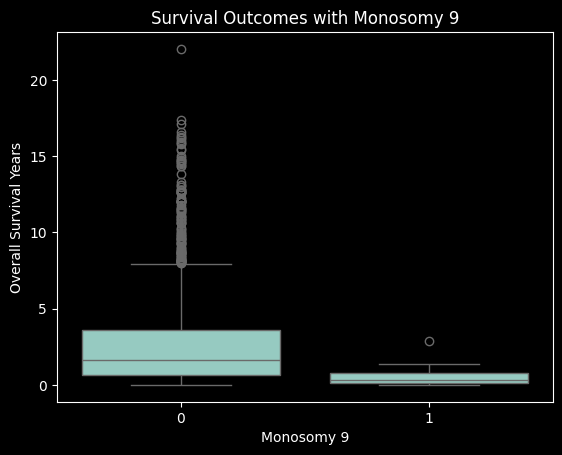

In [138]:
merged_mono = X.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 9', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 9')
plt.xlabel('Monosomy 9')
plt.ylabel('Overall Survival Years')
plt.show()


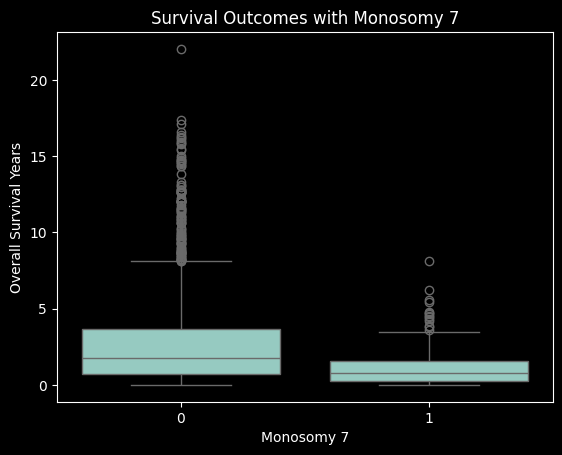

In [139]:
merged_mono = X.merge(target_df[['ID','OS_YEARS']], on='ID')
sns.boxplot(x='MONOSOMY 7', y='OS_YEARS', data=merged_mono)
plt.title('Survival Outcomes with Monosomy 7')
plt.xlabel('Monosomy 7')
plt.ylabel('Overall Survival Years')
plt.show()


In [140]:
"""
merged = X.merge(target_df, on='ID', how='left')
correlation_matrix = merged.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
"""

'\nmerged = X.merge(target_df, on=\'ID\', how=\'left\')\ncorrelation_matrix = merged.corr()\nplt.figure(figsize=(12, 10))\nsns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=\'coolwarm\')\nplt.title(\'Correlation Matrix\')\nplt.show()\n'

In [141]:
drop_features = ['ID', 'CENTER', 'CYTOGENETICS']
X = X.drop(columns=drop_features)

In [142]:
"""
evaluator = CoxModelEvaluator(X, y)
evaluator.evaluate_model(imputer=SimpleImputer(strategy='mean'),alpha=0.01)
"""

"\nevaluator = CoxModelEvaluator(X, y)\nevaluator.evaluate_model(imputer=SimpleImputer(strategy='mean'),alpha=0.01)\n"

#### Feature Importance

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [144]:
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

In [145]:
lgbm_params = {
    'max_depth': 3,
    'learning_rate': 0.05,
    'verbose': -1
}

X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
y_train_lgb = y_train['OS_STATUS']

train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
lgbm_model = lgb.train(lgbm_params, train_data, num_boost_round=1000)

train_ci_ipcw = concordance_index_ipcw(y_train, y_train, lgbm_model.predict(X_train_lgb), tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, lgbm_model.predict(X_test_lgb), tau=7)[0]
print(f"Train CI IPCW: {train_ci_ipcw:.4f}")
print(f"Test CI IPCW: {test_ci_ipcw:.4f}")

Train CI IPCW: 0.8129
Test CI IPCW: 0.6621


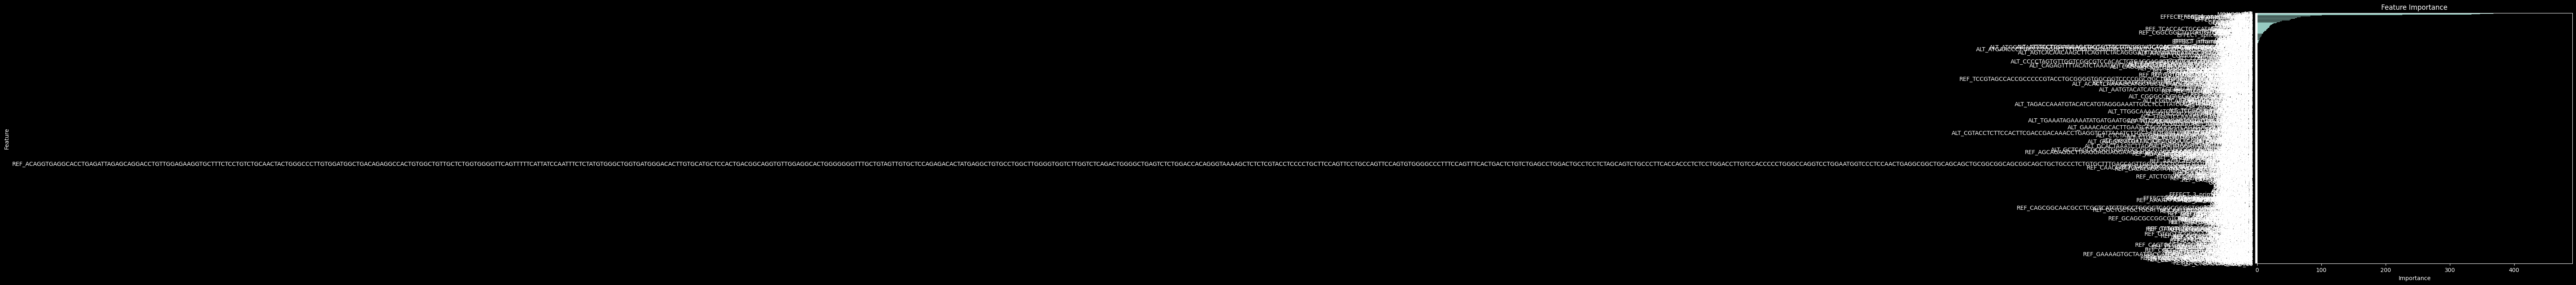

In [146]:
# Get feature importance
importance = lgbm_model.feature_importance()
feature_names = X.columns
feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})

# Sort the feature importance dataframe
feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_lgb)
plt.title('Feature Importance')
plt.show()

In [147]:
rf_params = {
    'max_depth': 3,
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1
}

rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train['OS_YEARS'])

train_ci_ipcw_rf = concordance_index_ipcw(y_train, y_train, rf_model.predict(X_train), tau=7)[0]
test_ci_ipcw_rf = concordance_index_ipcw(y_train, y_test, rf_model.predict(X_test), tau=7)[0]
print(f"Train CI IPCW RF: {train_ci_ipcw_rf:.4f}")
print(f"Test CI IPCW RF: {test_ci_ipcw_rf:.4f}")

Train CI IPCW RF: 0.2884
Test CI IPCW RF: 0.3151


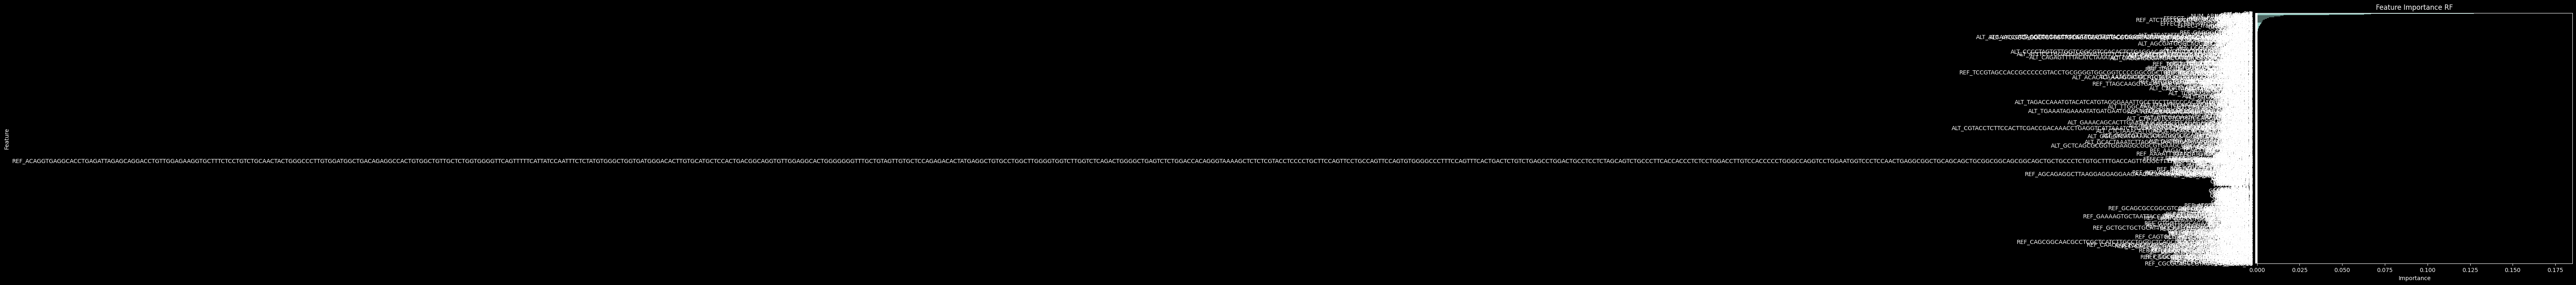

In [148]:
# Get feature importance
importance_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance_rf})
# Sort the feature importance dataframe
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
# Plot feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance RF')
plt.show()


In [149]:
feature_importance_df_lgb.head(10)

,Feature,Importance
4,HB,467
5,PLT,425
3,MONOCYTES,368
12,sum_VAF,359
13,sum_depth,347
1,WBC,334
2,ANC,242
0,BM_BLAST,226
264,REF_C,101
908,Cluster_2,90


In [150]:
feature_importance_df_rf.head(10)

,Feature,Importance
5,PLT,0.176062
4,HB,0.140210
909,Cluster_3,0.127211
0,BM_BLAST,0.099676
12,sum_VAF,0.066796
430,REF_GCTCT,0.062858
759,ALT_GCCCC,0.052658
1,WBC,0.042376
7,NUM_ABNORMALITIES,0.015592
9,Nb mut,0.014453


## Training

In [151]:
class RandomSurvivalForestEvaluator:
    def __init__(self, X, y, n_estimators=200, min_samples_split=30, min_samples_leaf=15, max_features=0.5, random_state=42, n_jobs=-1, n_splits=5):
        self.X = X
        self.y = y
        self.n_splits = n_splits
        self.kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        self.rsf = RandomSurvivalForest(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            random_state=random_state,
            n_jobs=n_jobs
        )
        self.rsf_cindex_train = []
        self.rsf_cindex_test = []

    def train(self):
        for train_index, test_index in self.kf.split(self.X, self.y):
            X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
            y_train, y_test = self.y[train_index], self.y[test_index]
            imputer = SimpleImputer(strategy='mean')
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            self.rsf.fit(X_train, y_train)

            rsf_cindex_train_val = concordance_index_ipcw(y_train, y_train, self.rsf.predict(X_train), tau=7)[0]
            rsf_cindex_test_val = concordance_index_ipcw(y_train, y_test, self.rsf.predict(X_test), tau=7)[0]
            self.rsf_cindex_train.append(rsf_cindex_train_val)
            self.rsf_cindex_test.append(rsf_cindex_test_val)

    def get_scores(self):
        print(f"Average Random Survival Forest IPCW-Index train: {np.mean(self.rsf_cindex_train):.4f}")
        print(f"Average Random Survival Forest IPCW-Index test: {np.mean(self.rsf_cindex_test):.4f}")
    
    def score_reset(self):
        self.rsf_cindex_test = []
        self.rsf_cindex_train = []

In [152]:
def grid_search_rsf(X, y, param_grid, n_splits=5, tau=7):
    """
    Perform grid search on RandomSurvivalForest with IPCW concordance index.

    Parameters:
    - X: DataFrame or array-like, feature matrix.
    - y: Structured array, survival data in sksurv format.
    - param_grid: Dictionary, parameter grid for RSF.
    - n_splits: Int, number of folds for cross-validation.
    - tau: Float, IPCW truncation time.

    Returns:
    - best_params: Dictionary, best parameter combination.
    - best_score: Float, best test concordance index score.
    """
    # Generate all parameter combinations
    param_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    # for later update of best score and parameters
    best_score = -np.inf
    best_params = None
    n = len(param_combinations)
    i = 0
    for params in param_combinations:
        # Initialize RSF with current parameter set
        rsf_params = dict(zip(param_names, params))
        rsf = RandomSurvivalForest(**rsf_params, random_state=42, n_jobs=-1)

        # Cross-validation setup
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        train_scores = []
        test_scores = []

        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Handle missing data
            imputer = SimpleImputer(strategy="mean")
            X_train = imputer.fit_transform(X_train)
            X_test = imputer.transform(X_test)
            
            # Fit RSF model
            rsf.fit(X_train, y_train)

            # Evaluate IPCW concordance index
            train_score = concordance_index_ipcw(y_train, y_train, rsf.predict(X_train), tau=tau)[0]
            test_score = concordance_index_ipcw(y_train, y_test, rsf.predict(X_test), tau=tau)[0]

            train_scores.append(train_score)
            test_scores.append(test_score)
        i += 1
        print(f"step {i}/{n}")
        # Average test score for this parameter set
        mean_test_score = np.mean(test_scores)
        print(f"Params: {rsf_params}, Train Score: {np.mean(train_scores):.4f}, Test Score: {mean_test_score:.4f}")

        # Update best parameters if the current score is better
        if mean_test_score > best_score:
            best_score = mean_test_score
            best_params = rsf_params

    return best_params, best_score


In [153]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
evaluator = RandomSurvivalForestEvaluator(X_scaled, y)
evaluator.train()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [154]:
evaluator.get_scores()

Average Random Survival Forest IPCW-Index train: 0.7963
Average Random Survival Forest IPCW-Index test: 0.7142


In [159]:
eval_rsf = RandomSurvivalForestEvaluator(X, y,n_estimators=100, min_samples_split=30, min_samples_leaf=15, max_features=0.7)
eval_rsf.train()

c:\Users\Loïc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [160]:
eval_rsf.get_scores()

Average Random Survival Forest IPCW-Index train: 0.7981
Average Random Survival Forest IPCW-Index test: 0.7137


In [157]:
"""
pca = PCA(0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
print(pca.explained_variance_ratio_)
X_pca = pd.DataFrame(X_pca)
eval_rsf_pca = RandomSurvivalForestEvaluator(X_pca, y)
eval_rsf_pca.train()
eval_rsf_pca.get_scores()
"""

'\npca = PCA(0.95)\nX_pca = pca.fit_transform(X)\nprint(X_pca.shape)\nprint(pca.explained_variance_ratio_)\nX_pca = pd.DataFrame(X_pca)\neval_rsf_pca = RandomSurvivalForestEvaluator(X_pca, y)\neval_rsf_pca.train()\neval_rsf_pca.get_scores()\n'

In [158]:
param_grid = {
    "n_estimators": [100,200],
    "min_samples_split": [5, 10,30],
    "min_samples_leaf": [2, 5,20],
    "max_features": ["sqrt"],
    "max_depth": [None, 5, 15]
}

#best_params, best_score = grid_search_rsf(X, y, param_grid, n_splits=5, tau=7)

#print("\nBest Parameters:", best_params)
#print("Best Test Concordance Index:", best_score)
